# Spin test

In [41]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [42]:
video_number = "7"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94018018162597, Total Frames: 332.0


Import ball center and radius

In [43]:
# Define the path to the CSV file
input_data_path = project_root / "notebook" / "ball_detection" / "intermediate_data" / f"Circle_positions_cleaned_{video_number}.csv"

# Load the CSV file into a DataFrame
ball_df = pd.read_csv(input_data_path)

Select a frame

In [44]:
# Set the video to the 30th frame (frame index starts from 0)
frame_number = 33
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

# Check if the frame was successfully read
if ret:
    print(f"Frame {frame_number} successfully read.")
else:
    print(f"Failed to read frame {frame_number}.")

Frame 33 successfully read.


Optical flow to see the ball movement

In [ ]:
# Extract ball center and radius from ball_df
ball_center = (int(ball_df.iloc[frame_number]['x']), int(ball_df.iloc[frame_number]['y']))
ball_radius = int(ball_df.iloc[frame_number]['radius'])

offset = 2

# Define the region of interest (ROI) around the ball
x_min = max(ball_center[0] - ball_radius, 0)-offset
x_max = min(ball_center[0] + ball_radius, frame.shape[1])+offset
y_min = max(ball_center[1] - ball_radius, 0)-offset
y_max = min(ball_center[1] + ball_radius, frame.shape[0])+offset
roi = frame[y_min:y_max, x_min:x_max]
copy_roi = roi.copy()
ball_center_roi = (ball_center[0] - x_min, ball_center[1] - y_min)
# Convert ROI to grayscale
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

# Parameters for optical flow
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# selezione 100 punti manuali distribuiti su 10 cerchi concentrici
manual_points = []
num_rings = 10  # numero di cerchi concentrici
points_per_ring = 10  # punti per ogni cerchio (10 × 10 = 100)
max_radius = ball_radius * 0.95  # lascia un margine vicino al bordo

for i in range(1, num_rings + 1):
    r = (i / num_rings) * max_radius
    for j in range(points_per_ring):
        theta = 2 * np.pi * j / points_per_ring
        x = int(ball_center_roi[0] + r * np.cos(theta))
        y = int(ball_center_roi[1] + r * np.sin(theta))
        manual_points.append((x, y))

# Converti in formato richiesto da calcOpticalFlowPyrLK
p0 = np.array(manual_points, dtype=np.float32).reshape(-1, 1, 2)

# Read the next frame for optical flow calculation
ret, next_frame = cap.read()
if not ret:
    raise ValueError(f"Failed to read the next frame after frame {frame_number}.")

# calculate the next ball center
ball_center_next = (int(ball_df.iloc[frame_number + 1]['x']), int(ball_df.iloc[frame_number + 1]['y']))
# as radius I need to use the previous in ordet to have roi of the same size

# Define the next ROI around the ball in the next frame
x_min_next = max(ball_center_next[0] - ball_radius, 0)-offset
x_max_next = min(ball_center_next[0] + ball_radius, next_frame.shape[1])+offset
y_min_next = max(ball_center_next[1] - ball_radius, 0)-offset
y_max_next = min(ball_center_next[1] + ball_radius, next_frame.shape[0])+offset
next_roi = next_frame[y_min_next:y_max_next, x_min_next:x_max_next]
ball_center_next_roi = (ball_center_next[0] - x_min_next, ball_center_next[1] - y_min_next)

next_roi_gray = cv2.cvtColor(next_roi, cv2.COLOR_BGR2GRAY)

# Calculate optical flow
p1, st, err = cv2.calcOpticalFlowPyrLK(roi_gray, next_roi_gray, p0, None, **lk_params)
# print('st:', st)
# print('p0:', p0)
# print('p1:', p1)
# print('err:', err)
# store the flow vectors
flow_vectors = [] 

# Filter good points
if p1 is not None and st is not None:
    # get the indeces where st==1 and err<10 -> more filtering
    good_indices = np.where((st.flatten() == 1) & (err < 10))[0]
    good_new = p1[good_indices].reshape(-1, 2)
    good_old = p0[good_indices].reshape(-1, 2)
    err_good = err[good_indices]
    # Filter only the point in the ball
    # Compute distances to the ball center
    dist_old = np.linalg.norm(good_old[:, :] - ball_center_roi, axis=1)
    dist_new = np.linalg.norm(good_new[:, :] - ball_center_next_roi, axis=1)

    # Create a mask of points that are within the ball in both frames
    within_radius_mask = (dist_old <= ball_radius) & (dist_new <= ball_radius)

    # Apply the mask
    good_old = good_old[within_radius_mask].reshape(-1, 2)
    good_new = good_new[within_radius_mask].reshape(-1, 2)

    # Visualize the optical flow
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        cv2.line(roi, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 1)
        cv2.circle(roi, (int(a), int(b)), 2, (0, 0, 255), -1)
        flow_vectors.append({
            'frame': frame_number,
            'point_id': i,
            'x_old': c,
            'y_old': d,
            'x_new': a,
            'y_new': b,
            'dx': a - c,
            'dy': b - d
        })
        # print(f"Point {i}: Old: ({c}, {d}), New: ({a}, {b}), dx: {a - c}, dy: {b - d}")

    # Display the ROI with optical flow
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title("Optical Flow in Ball ROI")
    plt.show()
else:
    print("No optical flow points detected.")

ValueError: cannot convert float NaN to integer

Center of Rotation: [ 42.606182 170.55429 ]
Average Angular Velocity: 0.28667789697647095 radians/frame


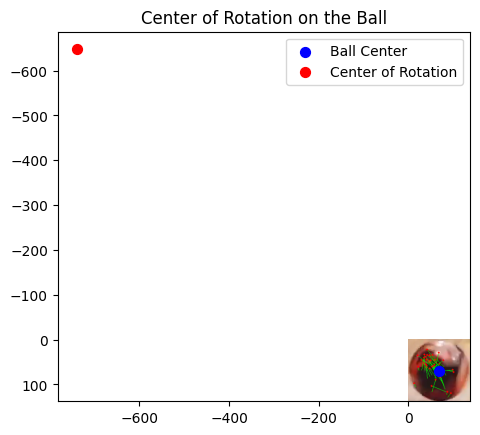

In [ ]:
# Convert good_old and good_new to numpy arrays for easier manipulation
good_old = np.array(good_old)
good_new = np.array(good_new)

# Compute the displacement vectors
displacements = good_new - good_old

# Define a function to compute the center of rotation
def compute_center_of_rotation(points, displacements):
    A = []
    b = []
    for (x, y), (dx, dy) in zip(points, displacements):
        A.append([2 * dx, 2 * dy])
        b.append([dx**2 + dy**2 - x**2 - y**2])
    A = np.array(A)
    b = np.array(b)
    center = np.linalg.lstsq(A, b, rcond=None)[0]
    return center.flatten()

# Compute the center of rotation
center_of_rotation = compute_center_of_rotation(good_old, displacements)

# Compute the angular velocity
distances_to_center = np.linalg.norm(good_old - center_of_rotation, axis=1)
angular_velocities = np.linalg.norm(displacements, axis=1) / distances_to_center
average_angular_velocity = np.mean(angular_velocities)

print(f"Center of Rotation: {center_of_rotation}")
print(f"Average Angular Velocity: {average_angular_velocity} radians/frame")

# Visualize the center of rotation on the ball
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.scatter(ball_center_roi[0], ball_center_roi[1], color='blue', label='Ball Center', s=50)
plt.scatter(center_of_rotation[0] - x_min, center_of_rotation[1] - y_min, color='red', label='Center of Rotation', s=50)
plt.legend()
plt.title("Center of Rotation on the Ball")
plt.show()

In [ ]:
def calculate_rotation_axis_and_velocity(p0, p1):
    # Assicurati che p0 e p1 siano array con la forma corretta
    p0 = np.array(p0)
    p1 = np.array(p1)

    # Calcolare il vettore differenza tra i due set di punti
    diff = p1 - p0  # diff avrà la forma (n, 2)
    
    # Calcolare la direzione dell'asse di rotazione (approssimato dalla media del movimento dei punti)
    axis = np.mean(diff, axis=0)
    
    # Normalizzare l'asse di rotazione
    axis = axis / np.linalg.norm(axis)
    
    # Calcolare l'angolo di rotazione tra i due set di punti
    p0_unit = p0 / np.linalg.norm(p0, axis=1, keepdims=True)
    p1_unit = p1 / np.linalg.norm(p1, axis=1, keepdims=True)
    
    # Calcolare il prodotto scalare tra i vettori unitari (ad esempio per ogni coppia di punti)
    cos_theta = np.sum(p0_unit * p1_unit, axis=1)  # Prodotto scalare per ogni coppia di punti
    
    # Assicurarsi che il coseno dell'angolo sia nel range valido per arccos
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Angolo di rotazione tra i punti (in radianti)
    angle = np.arccos(cos_theta)

    # Velocità angolare media
    angular_velocity = np.mean(angle)  # In radianti per frame
    
    return axis, angular_velocity
print(good_old)
# Calcola l'asse di rotazione e la velocità angolare
axis, angular_velocity = calculate_rotation_axis_and_velocity(good_old, good_new)

# Risultati
print("Asse di rotazione:", axis)
print("Velocità angolare (in radianti):", angular_velocity)

[[ 75.  69.]
 [ 75.  69.]
 [ 75.  69.]
 ...
 [ 17. 106.]
 [ 17. 106.]
 [ 17. 106.]]
Asse di rotazione: [-0.46933153 -0.88302195]
Velocità angolare (in radianti): 0.10390579


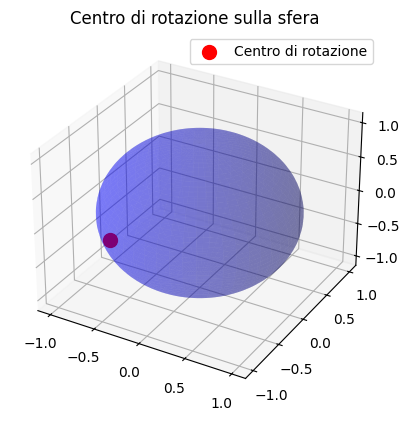

In [ ]:
axis = axis / np.linalg.norm(axis)  # Normalizza l'asse (per ottenere un vettore unitario)

# Raggio della sfera
R = ball_radius

# Supponiamo che axis rappresenti l'asse di rotazione (2D) che punta verso la sfera
rotation_center = np.append(axis, 0)  # Aggiungiamo una componente z pari a 0

# Ora rappresentiamo il centro di rotazione sulla sfera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crea una sfera per visualizzare il contesto
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Disegna la superficie della sfera
ax.plot_surface(x, y, z, color='b', alpha=0.3)

# Centro di rotazione
ax.scatter(rotation_center[0], rotation_center[1], rotation_center[2], color='r', s=100, label="Centro di rotazione")

# Etichetta
ax.set_title("Centro di rotazione sulla sfera")
ax.legend()

plt.show()

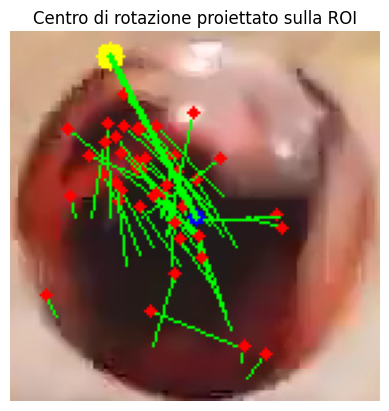

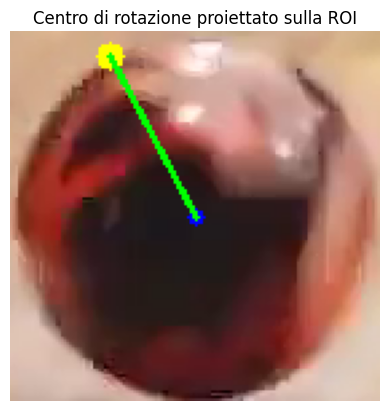

In [ ]:
# Proiezione dell'asse sulla superficie 2D
# Calcola l'intersezione dell'asse con la sfera in 3D (scalando l'asse per il raggio)
rotation_point_3d = axis * ball_radius  # punto sull'asse sulla superficie della sfera

# Proietta le coordinate 3D su 2D (ignorando la componente z)
rotation_point_2d = (int(ball_center_roi[0] + rotation_point_3d[0]),
                     int(ball_center_roi[1] + rotation_point_3d[1]))

# Disegna il punto sulla ROI
roi_with_rotation_center = roi.copy()
cv2.circle(roi_with_rotation_center, rotation_point_2d, 5, (0, 255, 255), -1)  # punto rosso
cv2.circle(roi_with_rotation_center, ball_center_roi, 3, (255, 0, 0), -1)   # centro della palla (blu)
cv2.line(roi_with_rotation_center, ball_center_roi, rotation_point_2d, (0, 255, 0), 2)  # asse proiettato

# Mostra l'immagine
plt.imshow(cv2.cvtColor(roi_with_rotation_center, cv2.COLOR_BGR2RGB))
plt.title("Centro di rotazione proiettato sulla ROI")
plt.axis("off")
plt.show()

# Disegna il punto sulla ROI
roi_with_rotation_center = copy_roi.copy()
cv2.circle(roi_with_rotation_center, rotation_point_2d, 5, (0, 255, 255), -1)  # punto rosso
cv2.circle(roi_with_rotation_center, ball_center_roi, 3, (255, 0, 0), -1)   # centro della palla (blu)
cv2.line(roi_with_rotation_center, ball_center_roi, rotation_point_2d, (0, 255, 0), 2)  # asse proiettato

# Mostra l'immagine
plt.imshow(cv2.cvtColor(roi_with_rotation_center, cv2.COLOR_BGR2RGB))
plt.title("Centro di rotazione proiettato sulla ROI")
plt.axis("off")
plt.show()

Generate a video

In [ ]:
# Percorso per salvare il video risultante
output_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"annotated_video_{video_number}.mp4"

# Ottieni le proprietà del video originale
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Inizializza il VideoWriter
out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

# Riposiziona il video all'inizio
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Itera su tutti i frame del video
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Controlla se il dato radius è presente per il frame corrente
    if frame_idx < len(ball_df) and not pd.isna(ball_df.iloc[frame_idx]['radius']) and not pd.isna(ball_df.iloc[frame_idx+1]['radius']):
        # Estrai il centro della palla e il raggio
        ball_center = (int(ball_df.iloc[frame_idx]['x']), int(ball_df.iloc[frame_idx]['y']))
        ball_radius = int(ball_df.iloc[frame_idx]['radius'])

        # Definisci la ROI per il frame corrente
        x_min = max(ball_center[0] - ball_radius, 0) - offset
        x_max = min(ball_center[0] + ball_radius, frame.shape[1]) + offset
        y_min = max(ball_center[1] - ball_radius, 0) - offset
        y_max = min(ball_center[1] + ball_radius, frame.shape[0]) + offset
        roi = frame[y_min:y_max, x_min:x_max]
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # selezione 100 punti manuali distribuiti su 10 cerchi concentrici
        manual_points = []
        num_rings = 10  # numero di cerchi concentrici
        points_per_ring = 10  # punti per ogni cerchio (10 × 10 = 100)
        max_radius = ball_radius * 0.95  # lascia un margine vicino al bordo

        for i in range(1, num_rings + 1):
            r = (i / num_rings) * max_radius
            for j in range(points_per_ring):
                theta = 2 * np.pi * j / points_per_ring
                x = int(ball_center_roi[0] + r * np.cos(theta))
                y = int(ball_center_roi[1] + r * np.sin(theta))
                manual_points.append((x, y))

        # Converti in formato richiesto da calcOpticalFlowPyrLK
        p0 = np.array(manual_points, dtype=np.float32).reshape(-1, 1, 2)

        # Calcola il flusso ottico per il frame corrente
        if frame_idx + 1 < len(ball_df):
            # print(f"Processing frame {frame_idx}...")
            ball_center_next = (int(ball_df.iloc[frame_idx + 1]['x']), int(ball_df.iloc[frame_idx + 1]['y']))
            x_min_next = max(ball_center_next[0] - ball_radius, 0) - offset
            x_max_next = min(ball_center_next[0] + ball_radius, frame.shape[1]) + offset
            y_min_next = max(ball_center_next[1] - ball_radius, 0) - offset
            y_max_next = min(ball_center_next[1] + ball_radius, frame.shape[0]) + offset
            next_roi = next_frame[y_min_next:y_max_next, x_min_next:x_max_next]
            next_roi_gray = cv2.cvtColor(next_roi, cv2.COLOR_BGR2GRAY)

            # Calcola il flusso ottico
            p1, st, err = cv2.calcOpticalFlowPyrLK(roi_gray, next_roi_gray, p0, None, **lk_params)

            # Filtra i punti validi
            if p1 is not None and st is not None:
                good_indices = np.where((st.flatten() == 1) & (err < 10))[0]
                good_new = p1[good_indices].reshape(-1, 2)
                good_old = p0[good_indices].reshape(-1, 2)
                # err_good = err[good_indices]

                # Calcola il centro di rotazione
                displacements = good_new - good_old
                axis, angular_velocity = calculate_rotation_axis_and_velocity(good_old, good_new)
                # print(f"Frame {frame_idx}: Axis: {axis}, Angular Velocity: {angular_velocity}")
                center_of_rotation = axis #* ball_radius

                # Calcola la posizione del centro di rotazione traslato
                rotation_point_2d = (
                    ball_center[0] + center_of_rotation[0],
                    ball_center[1] + center_of_rotation[1]
                )
                # Disegna il centro della palla
                cv2.circle(frame, ball_center, 5, (255, 0, 0), -1) # Blu
                
                if not np.isnan(rotation_point_2d[0]) and not np.isnan(rotation_point_2d[1]):
                    rotation_point_2d = (int(rotation_point_2d[0]), int(rotation_point_2d[1]))
                    # Disegna il centro di rotazione
                    cv2.circle(frame, rotation_point_2d, 5, (0, 255, 255), -1)  # Giallo
                    print(f"Frame {frame_idx}: Center of Rotation: {rotation_point_2d}")

    # Scrivi il frame nel video di output
    out.write(frame)

    # Incrementa l'indice del frame
    frame_idx += 1

# Rilascia le risorse
out.release()

print(f"Video annotato salvato in: {output_video_path}")

Frame 29: Center of Rotation: (809, 917)
Frame 30: Center of Rotation: (826, 904)
Frame 31: Center of Rotation: (835, 899)
Frame 32: Center of Rotation: (843, 891)
Frame 33: Center of Rotation: (849, 886)
Frame 34: Center of Rotation: (863, 884)
Frame 35: Center of Rotation: (868, 874)
Frame 36: Center of Rotation: (876, 862)
Frame 37: Center of Rotation: (885, 852)
Frame 38: Center of Rotation: (894, 840)
Frame 39: Center of Rotation: (902, 831)
Frame 40: Center of Rotation: (907, 823)
Frame 41: Center of Rotation: (916, 814)
Frame 42: Center of Rotation: (927, 804)
Frame 43: Center of Rotation: (932, 795)


C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Frame 45: Center of Rotation: (948, 781)
Frame 46: Center of Rotation: (956, 768)
Frame 47: Center of Rotation: (961, 759)
Frame 48: Center of Rotation: (964, 755)
Frame 50: Center of Rotation: (982, 734)
Frame 53: Center of Rotation: (996, 717)
Frame 54: Center of Rotation: (1004, 706)
Frame 55: Center of Rotation: (1008, 699)
Frame 56: Center of Rotation: (1013, 693)
Frame 62: Center of Rotation: (1046, 658)
Frame 63: Center of Rotation: (1047, 652)
Frame 64: Center of Rotation: (1056, 648)
Frame 68: Center of Rotation: (1072, 630)
Frame 70: Center of Rotation: (1079, 624)
Frame 71: Center of Rotation: (1080, 621)
Frame 72: Center of Rotation: (1084, 621)
Frame 75: Center of Rotation: (1097, 614)
Frame 78: Center of Rotation: (1107, 609)
Frame 79: Center of Rotation: (1112, 608)
Frame 81: Center of Rotation: (1117, 607)
Frame 83: Center of Rotation: (1123, 608)
Frame 84: Center of Rotation: (1128, 608)
Frame 86: Center of Rotation: (1132, 606)
Frame 87: Center of Rotation: (1136, 605

IndexError: single positional indexer is out-of-bounds